In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from gurobipy import Model, GRB

In [2]:
# From modules folder
from modules.models_execution import classificationModel, solve_opti_model
from modules.plots import plot_result, process_accuracy, process_opti_factors
from modules.active_learning import random_selection, uncertainty_selection, distribution_selection, duality_selection

# Baseline (full information)

**Classification Model - data**

In [3]:
df = pd.read_csv('data/habitat-suitability.csv')

**Classification Model - full information**

In [4]:
baseline_accuracy = []
for seed in range(1, 11):
    sample_accuracy, _, _ = classificationModel(df, seed=seed)
    baseline_accuracy.append(sample_accuracy)

baseline_accuracy = np.mean(baseline_accuracy)

**Optimization Model - data**

In [5]:
### READ DATA
# Reading CSV files
supply = pd.read_csv("data/opti-origin_supply.csv")["Value"].to_numpy()
tr_capacity = pd.read_csv("data/opti-transshipment_capacity.csv")["Value"].to_numpy()
des_capacity = pd.read_csv("data/opti-destination_capacity.csv")["Value"].to_numpy()

cost_1 = pd.read_csv("data/opti-origin_to_transshipment_cost.csv")
cost_1 = cost_1.pivot(index='Origin', columns='Hub', values='Value').fillna(0).to_numpy()

cost_2 = pd.read_csv("data/opti-transshipment_to_destination_cost.csv")
cost_2 = cost_2.pivot(index='Hub', columns='Destination', values='Value').fillna(0).to_numpy()

## To be used for I-SET active learning
cost_2 = pd.read_csv("data/opti-transshipment_to_destination_cost.csv")
cost_2 = cost_2.pivot(index='Hub', columns='Destination', values='Value').fillna(0).to_numpy()
cost_2_df = pd.DataFrame(cost_2)
cost_2_df = cost_2_df.reset_index().rename(columns={'index':'j'})
cost_2_df = cost_2_df.melt(id_vars=['j'], var_name='k', value_name='cost')

**Optimization Model - full information**

In [10]:
z = df['Suitable'].to_numpy()

opt_objective, df_X, df_Y, dual_df = solve_opti_model(z, supply, tr_capacity, des_capacity, cost_1, cost_2, df)

full_info_objective = opt_objective
df_Y_optimal = df_Y

# Active Learning

####  **Random Active Learning**

In [11]:
# Average across seeds to get a more robust result:
tot_accuracies = []
tot_objective_factor = []
tot_layout_factor = []

for seed in range(1, 6):
    print(f"Seed: {seed}")
    accuracies = {}
    losses = {}
    objective_factors = {}
    layout_factors = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    step = 50

    for size in range(50, 1000, step):
        ### RUN CLASSIFICATION MODEL        
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]
    
        ### COMPUTE FULL PREDICTION / Z HAT VECTOR
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])  # Adjust by setting the known labels

        ### RUN OPT MODEL
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy(), supply, tr_capacity, des_capacity, cost_1, cost_2, df)

        ### STORE OPTI KPIs 
        if opt_objective > 0: # feasible
            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)
            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()

            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor

        ### UPDATE SAMPLE
        current_sample, not_labelled_df = random_selection(current_sample, not_labelled_df, step, seed)
            
    tot_accuracies.append(accuracies)
    tot_objective_factor.append(objective_factors)
    tot_layout_factor.append(layout_factors)

Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5


Process and save results

In [12]:
accuracies_df_random, stats_sample_df_random, stats_full_df_random = process_accuracy(tot_accuracies)
accuracies_df_random.to_csv('results/accuracies/random_accuracy.csv')
stats_sample_df_random.to_csv('results/accuracies/random_accuracy_sample_stats.csv')
stats_full_df_random.to_csv('results/accuracies/random_accuracy_full_stats.csv')

layout_factor_random, objective_factor_random = process_opti_factors(tot_layout_factor, tot_objective_factor)
layout_factor_random.to_csv('results/layout/random_layout_factor.csv')
objective_factor_random.to_csv('results/objectives/random_objective_factor.csv')

#### **Uncertainty-based**

In [13]:
tot_accuracies_uncertainty = []
tot_objective_factor_uncertainty = []
tot_layout_factor_uncertainty = []

for seed in range(1, 6):
    print(f"{seed}")
    accuracies_u = {}
    objective_factors = {}
    layout_factors = {}

    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    step = 50
    
    for size in range(50, 1000, step):
        ### TRAIN CLASSIFICATION MODEL
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies_u[size] = [sample_acc, full_acc]

        ### COMPUTE FULL PREDICTION / Z HAT VECTOR
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        ### RUN OPTI MODEL
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy(), supply, tr_capacity, des_capacity, cost_1, cost_2, df)

        if opt_objective > 0: # feasible
            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)
            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()
            
            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor

        ### UPDATE SAMPLE
        # Uncertainty based
        current_sample, non_labelled_df = uncertainty_selection(current_sample, non_labelled_df, step, model, full_X_train_scaled)
            
    tot_accuracies_uncertainty.append(accuracies_u)
    tot_objective_factor_uncertainty.append(objective_factors)
    tot_layout_factor_uncertainty.append(layout_factors)

1
2
3
4
5


Process and save results

In [14]:
accuracies_uncertainty_df, stats_sample_uncertainty_df, stats_full_uncertainty_df = process_accuracy(tot_accuracies_uncertainty)
accuracies_uncertainty_df.to_csv('results/accuracies/uncertainty_accuracy.csv')
stats_sample_uncertainty_df.to_csv('results/accuracies/uncertainty_accuracy_sample_stats.csv')
stats_full_uncertainty_df.to_csv('results/accuracies/uncertainty_accuracy_full_stats.csv')

layout_factor_uncertainty, objective_factor_uncertainty = process_opti_factors(tot_layout_factor_uncertainty, tot_objective_factor_uncertainty)
layout_factor_uncertainty.to_csv('results/layout/uncertainty_layout_factor.csv')
objective_factor_uncertainty.to_csv('results/objectives/uncertainty_objective_factor.csv')

#### **Optimization-aware**

In [15]:
# Average across seeds to get a more robust result:
tot_accuracies_duality = []
tot_objective_factor_duality = []
tot_layout_factor_duality = []

for seed in range(1, 6):
    print(f"{seed}")
        
    accuracies = {}
    objective_factors = {}
    layout_factors = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        ### TRAIN CLASSIFICATION MODEL
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)  
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        ### COMPUTE FULL PREDICTION / Z HAT VECTOR
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        ### SOLVE OPTIMIZATION MODEL
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy(), supply, tr_capacity, des_capacity, cost_1, cost_2, df)

        ### STORE OPTI KPIs
        if opt_objective > 0: # feasible
            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)
            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()
            
            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor

        ### UPDATE SAMPLE
        current_sample, not_labelled_df = duality_selection(dual_df, df_Y, z_hat_df, current_sample, not_labelled_df, step, cost_2_df)
            
    tot_accuracies_duality.append(accuracies)
    tot_objective_factor_duality.append(objective_factors)
    tot_layout_factor_duality.append(layout_factors)


1
2
3
4
5


Process and save results

In [16]:
accuracies_df_duality, stats_sample_df_duality, stats_full_df_duality = process_accuracy(tot_accuracies_duality)

accuracies_df_duality.to_csv('results/accuracies/duality_accuracy.csv')
stats_sample_df_duality.to_csv('results/accuracies/duality_accuracy_sample_stats.csv')
stats_full_df_duality.to_csv('results/accuracies/duality_accuracy_full_stats.csv')

layout_factor_duality, objective_factor_duality = process_opti_factors(tot_layout_factor_duality, tot_objective_factor_duality)
layout_factor_duality.to_csv('results/layout/duality_layout_factor.csv')
objective_factor_duality.to_csv('results/objectives/duality_objective_factor.csv')

#### **Uncertainty-based + Optimization-aware**

In [18]:
# Average across seeds to get a more robust result:
tot_accuracies_uncertainty_duality = []
tot_objective_factor_uncertainty_duality = []
tot_layout_factor_uncertainty_duality = []

for seed in range(1, 6):
    print(f"{seed}")
        
    accuracies = {}
    objective_factors = {}
    layout_factors = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        ### TRAIN CLASSIFICATION MODEL
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)  
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        ### COMPUTE FULL PREDICTION / Z HAT VECTOR
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        ### SOLVE OPTIMIZATION MODEL
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy(), supply, tr_capacity, des_capacity, cost_1, cost_2, df)

        ### STORE OPTI KPIs
        if opt_objective > 0: # feasible
            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)
            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()
            
            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor

        ### UPDATE SAMPLE
        # Opt aware
        current_sample, not_labelled_df = duality_selection(dual_df, df_Y, z_hat_df, current_sample, not_labelled_df, int(step/2), cost_2_df)
        # Uncertainty based
        updated_full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        current_sample, not_labelled_df = uncertainty_selection(current_sample, not_labelled_df, int(step/2), model, updated_full_X_train_scaled)


    tot_accuracies_uncertainty_duality.append(accuracies)
    tot_objective_factor_uncertainty_duality.append(objective_factors)
    tot_layout_factor_uncertainty_duality.append(layout_factors)

1
2
3
4
5


In [19]:

accuracies_df_uncertainty_duality, stats_sample_df_uncertainty_duality, stats_full_df_uncertainty_duality = process_accuracy(tot_accuracies_uncertainty_duality)

accuracies_df_uncertainty_duality.to_csv('results/accuracies/uncertainty_duality_accuracy.csv')
stats_sample_df_uncertainty_duality.to_csv('results/accuracies/uncertainty_duality_accuracy_sample_stats.csv')
stats_full_df_uncertainty_duality.to_csv('results/accuracies/uncertainty_duality_accuracy_full_stats.csv')

layout_factor_uncertainty_duality, objective_factor_uncertainty_duality = process_opti_factors(tot_layout_factor_uncertainty_duality, tot_objective_factor_uncertainty_duality)
layout_factor_uncertainty_duality.to_csv('results/layout/uncertainty_duality_layout_factor.csv')
objective_factor_uncertainty_duality.to_csv('results/objectives/uncertainty_duality_objective_factor.csv')


#### **Feature Distribution-based**

In [73]:
tot_accuracies_distribution = []
tot_objective_factor_distribution = []
tot_layout_factor_distribution = []

for seed in range(1, 6):
    print(f"{seed}")
    accuracies_u = {}
    objective_factors = {}
    layout_factors = {}

    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    step = 100
    
    for size in range(50, 1000, step):
        ### TRAIN CLASSIFICATION MODEL
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies_u[size] = [sample_acc, full_acc]

        ### COMPUTE FULL PREDICTION / Z HAT VECTOR
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        ### RUN OPTI MODEL
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy(), supply, tr_capacity, des_capacity, cost_1, cost_2, df)

        ### STORE OPTI KPIs
        if opt_objective > 0: # feasible
            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)
            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()
            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor
            print('feasible')
        else:
            objective_factor = 1
            layout_factor = 1
            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor


        ### UPDATE SAMPLE
        # Dissimilarity based selection
        current_sample, not_labelled_df = distribution_selection(current_sample, not_labelled_df, step)
            
    ### SAVE PERFORMANCES
    tot_accuracies_distribution.append(accuracies_u)
    tot_objective_factor_distribution.append(objective_factors)
    tot_layout_factor_distribution.append(layout_factors)

1
feasible
feasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
2
feasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
3
feasible
feasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
4
feasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
5
feasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible


In [74]:
accuracies_distribution_df, stats_sample_distribution_df, stats_full_distribution_df = process_accuracy(tot_accuracies_distribution)
accuracies_distribution_df.to_csv('results/accuracies/distribution_accuracy.csv')
stats_sample_distribution_df.to_csv('results/accuracies/distribution_accuracy_sample_stats.csv')
stats_full_distribution_df.to_csv('results/accuracies/distribution_accuracy_full_stats.csv')

layout_factor_distribution, objective_factor_distribution = process_opti_factors(tot_layout_factor_distribution, tot_objective_factor_distribution)
layout_factor_distribution.to_csv('results/layout/distribution_layout_factor.csv')
objective_factor_distribution.to_csv('results/objectives/distribution_objective_factor.csv')

# Results

In [75]:
### READ RESULTS DATA
# Reading CSV files
random_accuracy = pd.read_csv("results/accuracies/random_accuracy.csv", index_col=0)
random_accuracy_sample_stats = pd.read_csv("results/accuracies/random_accuracy_sample_stats.csv", index_col=0)
random_accuracy_full_stats = pd.read_csv("results/accuracies/random_accuracy_full_stats.csv", index_col=0)
random_layout_factor = pd.read_csv("results/layout/random_layout_factor.csv")
random_objective_factor = pd.read_csv("results/objectives/random_objective_factor.csv")

uncertainty_accuracy = pd.read_csv("results/accuracies/uncertainty_accuracy.csv", index_col=0)
uncertainty_accuracy_sample_stats = pd.read_csv("results/accuracies/uncertainty_accuracy_sample_stats.csv", index_col=0)
uncertainty_accuracy_full_stats = pd.read_csv("results/accuracies/uncertainty_accuracy_full_stats.csv", index_col=0)
uncertainty_layout_factor = pd.read_csv("results/layout/uncertainty_layout_factor.csv")
uncertainty_objective_factor = pd.read_csv("results/objectives/uncertainty_objective_factor.csv")

duality_accuracy = pd.read_csv("results/accuracies/duality_accuracy.csv",index_col=0)
duality_accuracy_sample_stats = pd.read_csv("results/accuracies/duality_accuracy_sample_stats.csv", index_col=0)
duality_accuracy_full_stats = pd.read_csv("results/accuracies/duality_accuracy_full_stats.csv", index_col=0)
duality_layout_factor = pd.read_csv("results/layout/duality_layout_factor.csv")
duality_objective_factor = pd.read_csv("results/objectives/duality_objective_factor.csv")

uncertainty_duality_accuracy = pd.read_csv("results/accuracies/uncertainty_duality_accuracy.csv", index_col=0)
uncertainty_duality_accuracy_sample_stats = pd.read_csv("results/accuracies/uncertainty_duality_accuracy_sample_stats.csv", index_col=0)
uncertainty_duality_accuracy_full_stats = pd.read_csv("results/accuracies/uncertainty_duality_accuracy_full_stats.csv", index_col=0)
uncertainty_duality_layout_factor = pd.read_csv("results/layout/uncertainty_duality_layout_factor.csv")
uncertainty_duality_objective_factor = pd.read_csv("results/objectives/uncertainty_duality_objective_factor.csv")

distribution_accuracy = pd.read_csv("results/accuracies/distribution_accuracy.csv", index_col=0)
distribution_accuracy_sample_stats = pd.read_csv("results/accuracies/distribution_accuracy_sample_stats.csv", index_col=0)
distribution_accuracy_full_stats = pd.read_csv("results/accuracies/distribution_accuracy_full_stats.csv", index_col=0)
distribution_layout_factor = pd.read_csv("results/layout/distribution_layout_factor.csv")
distribution_objective_factor = pd.read_csv("results/objectives/distribution_objective_factor.csv")

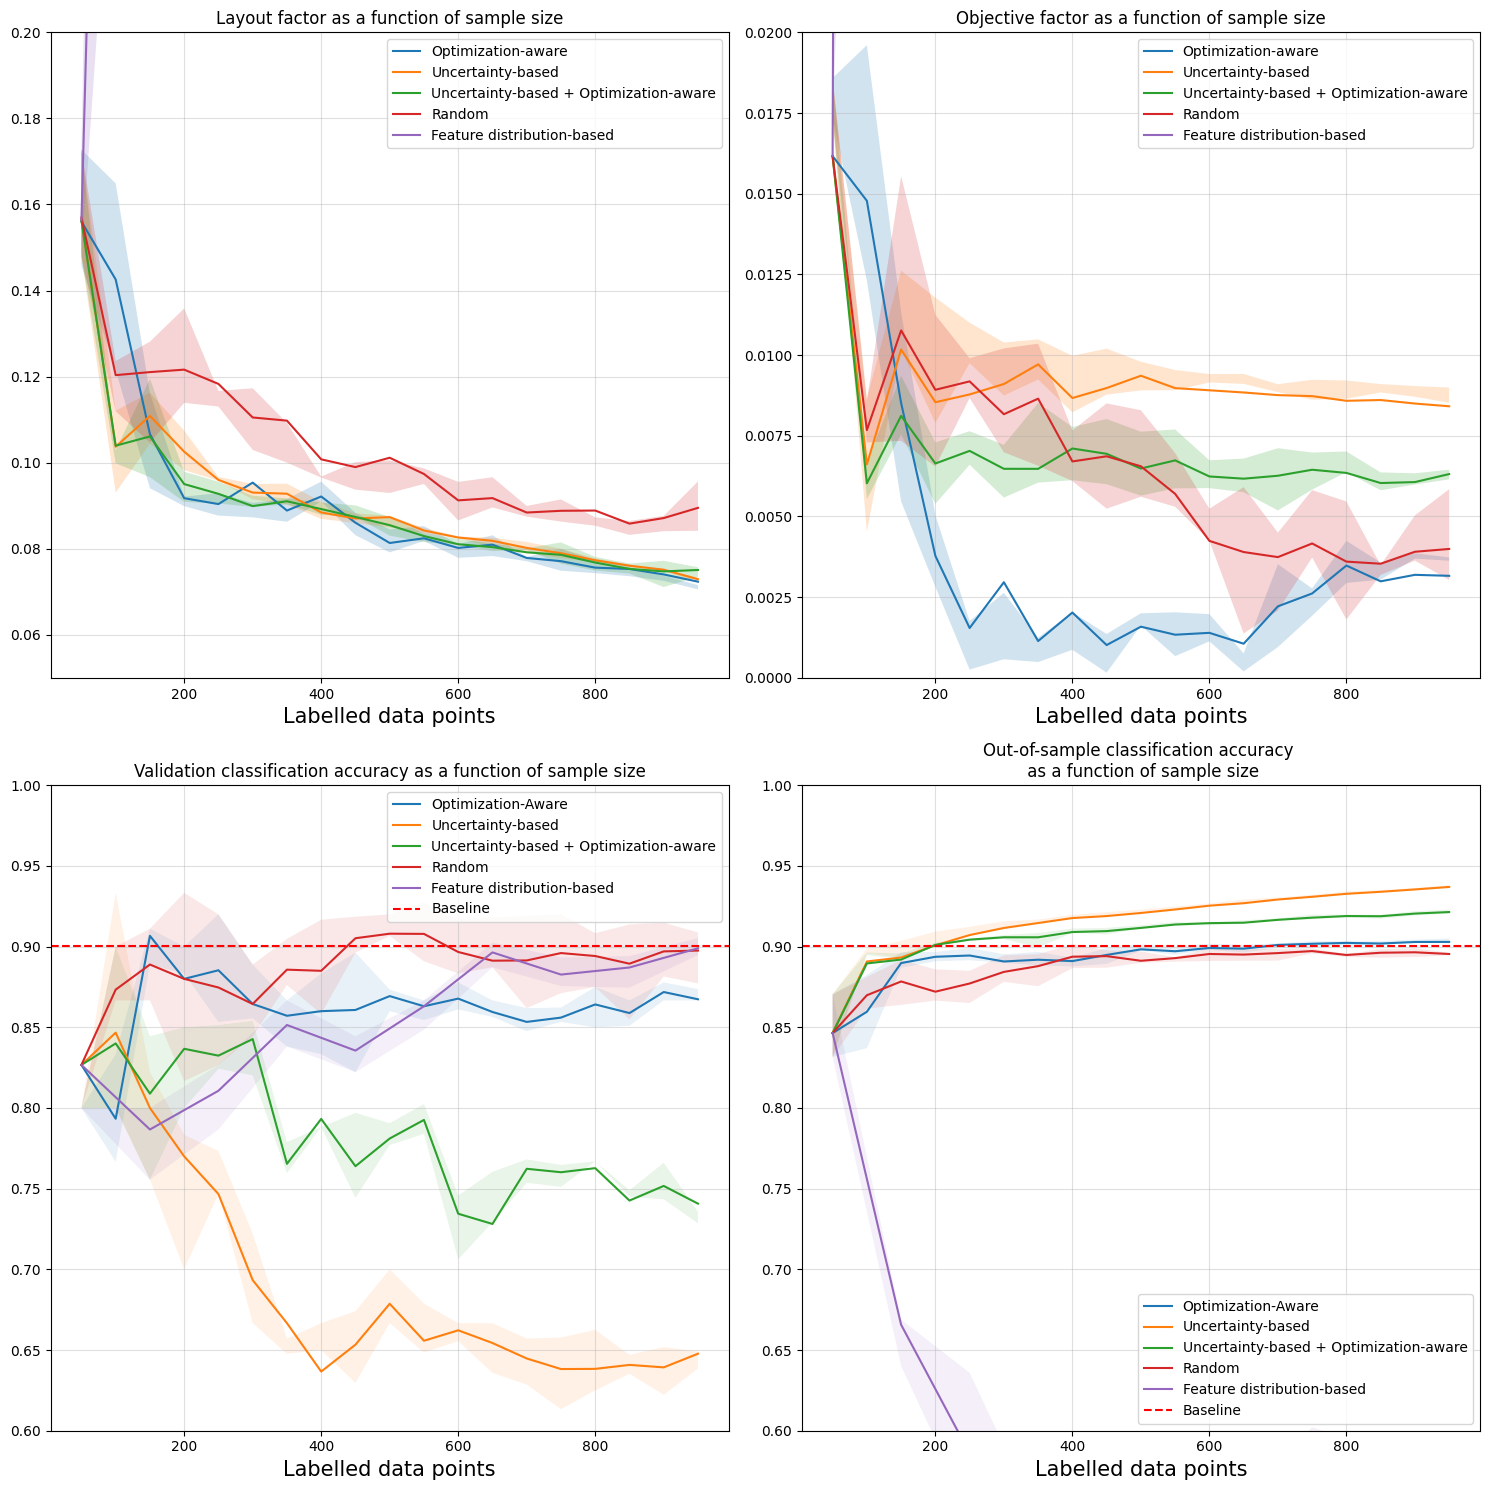

In [76]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

duality_layout_factor.plot(x='Size', y='average', ax=ax[0][0], label='Optimization-aware')
ax[0][0].fill_between(duality_layout_factor['Size'], duality_layout_factor['first_qnt'], duality_layout_factor['third_qnt'], alpha=0.2)
uncertainty_layout_factor.plot(x='Size', y='average', ax=ax[0][0], label='Uncertainty-based')
ax[0][0].fill_between(uncertainty_layout_factor['Size'], uncertainty_layout_factor['first_qnt'], uncertainty_layout_factor['third_qnt'], alpha=0.2)
uncertainty_duality_layout_factor.plot(x='Size', y='average', ax=ax[0][0], label='Uncertainty-based + Optimization-aware')
ax[0][0].fill_between(uncertainty_duality_layout_factor['Size'], uncertainty_duality_layout_factor['first_qnt'], uncertainty_duality_layout_factor['third_qnt'], alpha=0.2)
random_layout_factor.plot(x='Size', y='average', ax=ax[0][0], label='Random')
ax[0][0].fill_between(random_layout_factor['Size'], random_layout_factor['first_qnt'], random_layout_factor['third_qnt'], alpha=0.2)
distribution_layout_factor.plot(x='Size', y='average', ax=ax[0][0], label='Feature distribution-based')
ax[0][0].fill_between(distribution_layout_factor['Size'], distribution_layout_factor['first_qnt'], distribution_layout_factor['third_qnt'], alpha=0.2)
ax[0][0].set_ylim([0.05,0.2])
ax[0][0].set_title('Layout factor as a function of sample size')
ax[0][0].set_xlabel('Labelled data points', fontsize=15)
ax[0][0].grid(True, alpha=0.4)

duality_objective_factor.plot(x='Size', y='average', ax=ax[0][1], label='Optimization-aware')
ax[0][1].fill_between(duality_objective_factor['Size'], duality_objective_factor['first_qnt'], duality_objective_factor['third_qnt'], alpha=0.2)
uncertainty_objective_factor.plot(x='Size', y='average', ax=ax[0][1], label='Uncertainty-based')
ax[0][1].fill_between(uncertainty_objective_factor['Size'], uncertainty_objective_factor['first_qnt'], uncertainty_objective_factor['third_qnt'], alpha=0.2)
uncertainty_duality_objective_factor.plot(x='Size', y='average', ax=ax[0][1], label='Uncertainty-based + Optimization-aware')
ax[0][1].fill_between(uncertainty_duality_objective_factor['Size'], uncertainty_duality_objective_factor['first_qnt'], uncertainty_duality_objective_factor['third_qnt'], alpha=0.2)
random_objective_factor.plot(x='Size', y='average', ax=ax[0][1], label='Random')
ax[0][1].fill_between(random_objective_factor['Size'], random_objective_factor['first_qnt'], random_objective_factor['third_qnt'], alpha=0.2)
distribution_objective_factor.plot(x='Size', y='average', ax=ax[0][1], label='Feature distribution-based')
ax[0][1].fill_between(distribution_objective_factor['Size'], distribution_objective_factor['first_qnt'], distribution_objective_factor['third_qnt'], alpha=0.2)
ax[0][1].set_ylim([0,0.02])
ax[0][1].set_title('Objective factor as a function of sample size')
ax[0][1].set_xlabel('Labelled data points', fontsize=15)
ax[0][1].grid(True, alpha=0.4)

ax[1][0].plot(duality_accuracy.reset_index()['index'], duality_accuracy['Sample Accuracy'], label='Optimization-Aware')
ax[1][0].fill_between(duality_accuracy.reset_index()['index'], duality_accuracy_sample_stats['25%'], duality_accuracy_sample_stats['75%'], alpha=0.1)
ax[1][0].plot(uncertainty_accuracy.reset_index()['index'], uncertainty_accuracy['Sample Accuracy'], label='Uncertainty-based')
ax[1][0].fill_between(uncertainty_accuracy.reset_index()['index'], uncertainty_accuracy_sample_stats['25%'], uncertainty_accuracy_sample_stats['75%'], alpha=0.1)
ax[1][0].plot(uncertainty_duality_accuracy.reset_index()['index'], uncertainty_duality_accuracy['Sample Accuracy'], label='Uncertainty-based + Optimization-aware')
ax[1][0].fill_between(uncertainty_duality_accuracy.reset_index()['index'], uncertainty_duality_accuracy_sample_stats['25%'], uncertainty_duality_accuracy_sample_stats['75%'], alpha=0.1)
ax[1][0].plot(random_accuracy.reset_index()['index'], random_accuracy['Sample Accuracy'], label='Random')
ax[1][0].fill_between(random_accuracy.reset_index()['index'], random_accuracy_sample_stats['25%'], random_accuracy_sample_stats['75%'], alpha=0.1)
ax[1][0].plot(distribution_accuracy.reset_index()['index'], distribution_accuracy['Sample Accuracy'], label='Feature distribution-based')
ax[1][0].fill_between(distribution_accuracy.reset_index()['index'], distribution_accuracy_sample_stats['25%'], distribution_accuracy_sample_stats['75%'], alpha=0.1)
ax[1][0].axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
ax[1][0].set_title('Validation classification accuracy as a function of sample size')
ax[1][0].set_ylim([0.60,1])
ax[1][0].grid(True, alpha=0.4)
ax[1][0].set_xlabel('Labelled data points', fontsize=15)
ax[1][0].legend()

ax[1][1].plot(duality_accuracy.reset_index()['index'], duality_accuracy['Full Accuracy'], label='Optimization-Aware')
ax[1][1].fill_between(duality_accuracy.reset_index()['index'], duality_accuracy_full_stats['25%'], duality_accuracy_full_stats['75%'], alpha=0.1)
ax[1][1].plot(uncertainty_accuracy.reset_index()['index'], uncertainty_accuracy['Full Accuracy'], label='Uncertainty-based')
ax[1][1].fill_between(uncertainty_accuracy.reset_index()['index'], uncertainty_accuracy_full_stats['25%'], uncertainty_accuracy_full_stats['75%'], alpha=0.1)
ax[1][1].plot(uncertainty_duality_accuracy.reset_index()['index'], uncertainty_duality_accuracy['Full Accuracy'], label='Uncertainty-based + Optimization-aware')
ax[1][1].fill_between(uncertainty_duality_accuracy.reset_index()['index'], uncertainty_duality_accuracy_full_stats['25%'], uncertainty_duality_accuracy_full_stats['75%'], alpha=0.1)
ax[1][1].plot(random_accuracy.reset_index()['index'], random_accuracy['Full Accuracy'], label='Random')
ax[1][1].fill_between(random_accuracy.reset_index()['index'], random_accuracy_full_stats['25%'], random_accuracy_full_stats['75%'], alpha=0.1)
ax[1][1].plot(distribution_accuracy.reset_index()['index'], distribution_accuracy['Full Accuracy'], label='Feature distribution-based')
ax[1][1].fill_between(distribution_accuracy.reset_index()['index'], distribution_accuracy_full_stats['25%'], distribution_accuracy_full_stats['75%'], alpha=0.1)
ax[1][1].set_title('Out-of-sample classification accuracy \n as a function of sample size')
ax[1][1].axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
ax[1][1].set_ylim([0.60,1])
ax[1][1].set_xlabel('Labelled data points', fontsize=15)
ax[1][1].grid(True, alpha=0.4)
ax[1][1].legend()

plt.legend()
plt.tight_layout()
plt.show()

Questions:

- Feature distribution based sucks so much (out of sample) that it make the opt problem infeasible. Why is this the case? is it because of our dataset? If so, what are the charactheristics of it that make it such?

- (from Alex) Why is uncertainty-based good in layout but bad in objective? perhaps because by construction there's no guarantee that this is not the case -- Answer: in one direction, it is possible that the model is very close in terms of objective function but far in terms of network layout. This is obvious. It can also be very close in terms of layout/vector, but far in terms of objective. This happens if the model is right about most of the points, but wrong about the most important ones. Indeed, this happens in the uncertainty-based, but not in the optimization-aware, which is designed to keep duality information in mind (select the most important ones)

- Why is uncertainty-based + optimization-aware worse than random on objective after a certain point? -- it's because opt-aware goes up after 500 (why?)

TODO:

- list of key info from this plots